In [7]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [8]:
from b2heavy.FnalHISQMetadata import params as mData

In [9]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [35]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [36]:
# ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
ENSEMBLE_LIST = ['Coarse-2','Coarse-1','Coarse-Phys','Fine-1']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['xfstpar','RA1','ZRA1','XV','R0','R1']

In [38]:
Rs = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        for rat in RATIO_LIST:
            try:
                fit,res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                    path = DATA_2PT
                )
                r = res['ratio'][0]

                if rat=='RA1':
                    r = np.sqrt(r)
                elif rat=='ZRA1':
                    r = np.sqrt(gv.gvar(-r.mean,r.sdev))


            except FileNotFoundError:
                r = None
            aux[rat] = r

            if rat=='xfstpar':
                try:
                    aux['wrecoil'] = (1+r**2)/(1-r**2)
                except TypeError:
                    aux['wrecoil'] = None
        Rs.append(aux)

Rs = pd.DataFrame(Rs).set_index(['ensemble','mom'])
Rs

xfstpar     wrecoil         RA1        ZRA1          XV  \
ensemble    mom                                                                
Coarse-2    000         None        None        None   0.921(12)        None   
            100  -0.1108(47)  1.0248(21)  0.8695(92)        None   0.304(13)   
            200   -0.219(12)   1.101(12)   0.810(21)        None   0.577(50)   
            300   -0.262(39)   1.148(48)   0.746(52)        None   0.781(55)   
            400         None        None        None        None        None   
Coarse-1    000         None        None        None   0.899(23)        None   
            100   -0.094(26)   1.018(10)   0.944(10)        None   0.257(39)   
            200   -0.164(27)   1.055(19)   0.928(33)        None   0.481(53)   
            300   -0.212(34)   1.094(32)   0.919(39)        None   0.591(16)   
            400         None        None        None        None        None   
Coarse-Phys 000         None        None        None  0.9097(73)        None   
            100  -0.0539(48)  1.0058(10)   0.902(15)        None   0.157(12)   
            200  -0.1072(58)  1.0232(25)   0.891(12)        None   0.334(29)   
            300  -0.1577(68)  1.0510(45)   0.891(23)        None   0.466(45)   
            400  -0.2074(88)  1.0899(80)   0.817(29)        None   0.553(42)   
Fine-1      000         None        None        None  0.9115(93)        None   
            100   -0.093(22)  1.0173(83)  0.9013(85)        None  0.1852(62)   
            200  -0.1454(65)  1.0432(40)   0.883(13)        None  0.3826(56)   
            300  -0.2052(73)  1.0879(65)   0.847(26)        None  0.5568(90)   
            400   -0.256(12)   1.141(14)   0.911(48)        None   0.742(35)   

                          R0         R1  
ensemble    mom                          
Coarse-2    000         None       None  
            100  -0.1649(86)  2.154(42)  
            200   -0.352(23)  2.549(83)  
            300   -0.598(74)  3.068(97)  
            400         None       None  
Coarse-1    000         None       None  
            100   -0.160(46)  2.124(22)  
            200   -0.290(52)  2.338(36)  
            300   -0.411(62)  2.649(70)  
            400         None       None  
Coarse-Phys 000         None       None  
            100  -0.0757(57)  2.079(18)  
            200  -0.1524(48)  2.188(25)  
            300  -0.2349(70)  2.372(51)  
            400   -0.308(17)  2.465(55)  
Fine-1      000         None       None  
            100  -0.0998(49)  2.015(15)  
            200  -0.2072(78)  2.247(57)  
            300   -0.347(34)  2.497(77)  
            400   -0.481(54)  2.932(95)

In [39]:
FF = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}

        w   = Rs['wrecoil'].loc[ens,mom]
        RA1 = Rs['RA1'    ].loc[ens,mom]
        XV  = Rs['XV'     ].loc[ens,mom]
        X0  = Rs['R0'     ].loc[ens,mom]
        X1  = Rs['R1'     ].loc[ens,mom]

        if w is None:
            continue
        
        aux['wrecoil'] = w
        aux['hA1']     = 2*RA1/(w+1)
        aux['hA2']     = 2*RA1/np.sqrt(w**2-1) * (w*X1 - np.sqrt(w**2-1)*X0-1)
        aux['hA3']     = 2*RA1/np.sqrt(w**2-1)(w-X1)
        aux['hV']      = 2*RA1/np.sqrt(w**2-1) * XV

        FF.append(aux)

FF = pd.DataFrame(FF).set_index(['ensemble','mom'])
FF

wrecoil         hA1        hA2         hA3        hV
ensemble    mom                                                         
Coarse-2    100  1.0248(21)  0.8588(91)   9.65(51)   7.934(84)  2.36(14)
            200   1.101(12)   0.771(20)   6.93(46)   3.456(88)  2.03(22)
            300   1.148(48)   0.695(50)   7.57(98)    2.70(19)  2.07(41)
Coarse-1    100   1.018(10)   0.936(11)  11.8(3.1)   11.77(13)  2.55(82)
            200   1.055(19)   0.904(34)   8.6(1.2)    4.17(15)  2.65(55)
            300   1.094(32)   0.878(40)   8.6(1.2)    4.27(18)  2.45(45)
Coarse-Phys 100  1.0058(10)   0.899(15)  18.3(1.7)   17.73(29)  2.62(31)
            200  1.0232(25)   0.881(12)  10.45(57)    8.08(11)  2.75(29)
            300  1.0510(45)   0.869(23)   8.65(49)    5.27(14)  2.57(28)
            400  1.0899(80)   0.782(28)   6.86(40)    3.62(13)  2.09(20)
Fine-1      100  1.0173(83)  0.8935(92)  10.3(2.3)  10.378(98)  1.78(44)
            200  1.0432(40)   0.864(13)   8.35(49)   6.065(87)  2.27(12)
            300  1.0879(65)   0.811(25)   7.37(45)    4.33(13)  2.20(11)
            400   1.141(14)   0.851(45)   8.66(65)    3.39(18)  2.47(22)

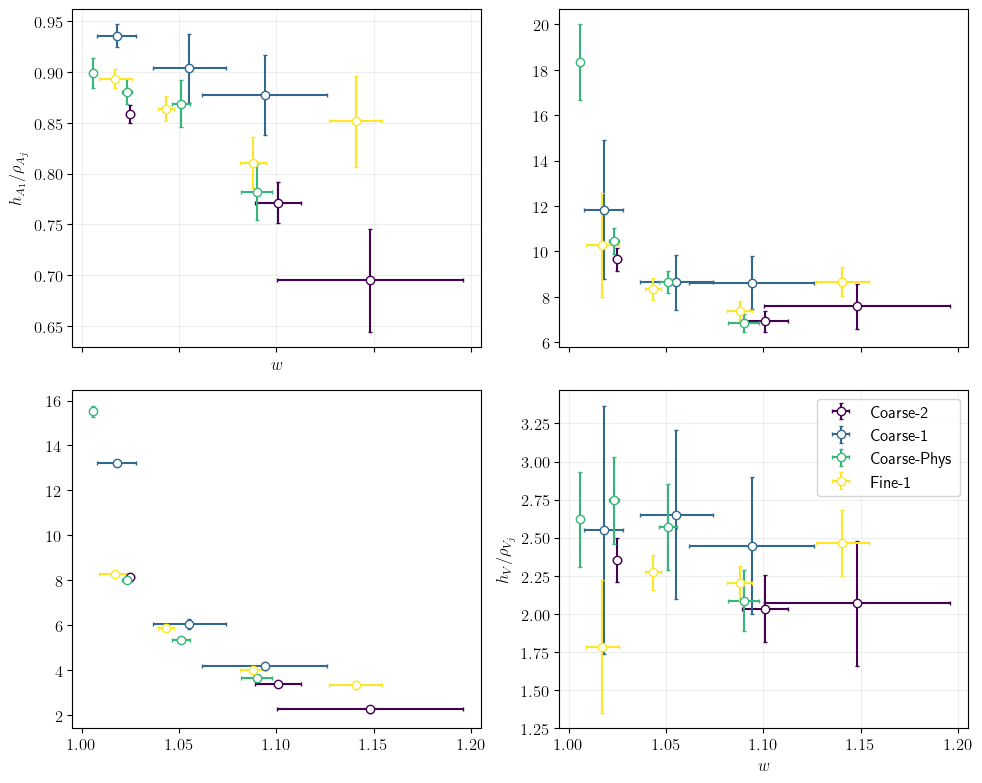

In [34]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(2,2,figsize=(10,8),sharex=True)


color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0,0].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA1'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA1'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1,1].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hV'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hV'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[0,1].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA2'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA2'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1,0].errorbar(
        gv.mean(FF['wrecoil'].loc[ens].values),
        gv.mean(FF['hA3'].loc[ens].values),
        xerr = gv.sdev(FF['wrecoil'].loc[ens].values),
        yerr = gv.sdev(FF['hA3'].loc[ens].values),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    # ax.errorbar(xin+off,gv.mean(yin),gv.sdev(yin),fmt=mrk[i%2], ecolor=color, mfc='w', color=color, capsize=2.5,alpha=alpha)

ax[0,0].set_ylabel(r'$h_{A_1}/\rho_{A_j}$')
ax[0,0].set_xlabel(r'$w$')
ax[0,0].grid(alpha=0.2)

ax[1,1].legend()
ax[1,1].set_ylabel(r'$h_V/\rho_{V_j}$')
ax[1,1].set_xlabel(r'$w$')
ax[1,1].grid(alpha=0.2)

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/ff.pdf')
